## OpenML Materialization Experiment
In this notebook, we make the plots in Figure 7 (a) and (b) of Section 6.3.

Experiment result is located here:

'./experiment_results/remote/model_materialization/openml/cloud-41/2019-10-21/09-20.csv'


In [246]:
# numpy and pandas for data manipulation
import sys
# Suppress warnings
import warnings
import seaborn as sns
import matplotlib as plt
import networkx as nx
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import os
#from __future__ import unicode_literals
import matplotlib2tikz
plt.style.use('seaborn')
sns.set(style="whitegrid")
sns.set_style({'grid.color': '.5'})
plt.rc('hatch', color='white', linewidth=1)
plt.use('pgf')

FONT_SIZE = 30
LW=5

plt.rcParams.update({
    "lines.markersize": 20,
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,   
    "font.family": "serif",
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": FONT_SIZE,     
    "font.size": FONT_SIZE,
    "legend.fontsize": FONT_SIZE, 
    "xtick.labelsize": FONT_SIZE,
    "ytick.labelsize": FONT_SIZE,
    #"figure.figsize": figsize(1.0), 
     "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
})
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
ROOT_RESULT_FOLDER = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/experiment_results'


SYSTEM_COLOR = sns.color_palette()[0]
BASELINE_COLOR = sns.color_palette()[1]

BASELINE_COLOR_2 = sns.color_palette()[2]
BASELINE_COLOR_3 = sns.color_palette()[3]
BASELINE_COLOR_4 = sns.color_palette()[4]
BASELINE_COLOR_5 = sns.color_palette()[5]
BASELINE_COLOR_6 = sns.color_palette()[6]
BASELINE_COLOR_7 = sns.color_palette()[7]

WRITE_DIRECTORY_ROOT = \
'/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/papers/images/experiment-results'

output_directory = WRITE_DIRECTORY_ROOT + '/openml/model_materialization'
def create_folder(path):
    if not os.path.exists(os.path.dirname(path)):
        try:
            os.makedirs(os.path.dirname(path))
        except OSError as exc:  # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
def savefig(filename):
    plt.savefig('{}.pgf'.format(filename), bbox_inches='tight')
    plt.savefig('{}.pdf'.format(filename), bbox_inches='tight')

In [247]:
MODE = 'remote'
result_folder = ROOT_RESULT_FOLDER + '/' + MODE + '/model_materialization/openml'
result_file = result_folder + '/cloud-41/2019-10-21/09-20.csv'

In [248]:
HEADERS = [
    'timestamp', 'exp_id', 'repo', 'pipeline', 'setup', 'type', 'mat_budget','score',
    'current_run_time', 'best_setup', 'best_pipeline', 'best_score',
    'best_run_time', 'total_run_time'
]

method_map = {'optimized': 'CO', 'baseline': 'OML'}
model_mat_times = pd.read_csv(result_file, header=None, names=HEADERS)

model_mat_times['cumulative_best_run_time'] = model_mat_times.groupby(['exp_id', 'type','mat_budget'])['best_run_time'].apply(lambda x: x.cumsum())
model_mat_times['cumulative_run_time'] = model_mat_times.groupby(['exp_id', 'type','mat_budget'])['total_run_time'].apply(lambda x: x.cumsum())
model_mat_times['mat_budget'] = model_mat_times['mat_budget'] / (1024. * 1024.)
model_mat_times['cumulative_current_run_time'] = model_mat_times.groupby(['exp_id', 'type','mat_budget'])['current_run_time'].apply(lambda x: x.cumsum())
model_mat_times['workload'] = model_mat_times.groupby(['exp_id', 'type','mat_budget']).cumcount() + 1
model_mat_times['type'] = model_mat_times['type'].replace(method_map)

In [249]:
# MODE = 'remote'
# result_folder = ROOT_RESULT_FOLDER + '/' + MODE + '/alpha_impact/openml'
# result_file = result_folder + '/cloud-41/2019-10-18/22-27.csv'
MODE = 'remote'
result_folder = ROOT_RESULT_FOLDER + '/' + MODE + '/alpha_impact/openml'
result_file = result_folder + '/cloud-41/2019-10-20/11-30.csv'
HEADERS = [
    'timestamp', 'exp_id', 'repo', 'pipeline', 'setup', 'mat_type', 'alpha',
    'mat_status', 'total_run_time'
]

method_map = {'optimized': 'CO', 'baseline': 'OML'}
alpha_times = pd.read_csv(result_file, header=None, names=HEADERS)
alpha_times['cumulative_run_time'] = alpha_times.groupby(
    ['exp_id', 'mat_type',
     'alpha'])['total_run_time'].apply(lambda x: x.cumsum())
alpha_times['cumulative_mat_status'] = alpha_times.groupby(
    ['exp_id', 'mat_type', 'alpha'])['mat_status'].apply(lambda x: x.cumsum())
alpha_times['workload'] = alpha_times.groupby(
    ['exp_id', 'mat_type', 'alpha']).cumcount() + 1

alpha_times['mat_type'] = [
    'a-{}'.format(x['alpha']) if (x['mat_type'] == 'best_n') else x['mat_type']
    for i, x in alpha_times[['mat_type', 'alpha']].iterrows()
]
df = pd.concat([alpha_times[alpha_times.mat_type == 'oracle'][['cumulative_run_time','cumulative_mat_status']]]*8, ignore_index=True)
alpha_times[['oracle_time','oracle_count']] = df
alpha_times['diff_time'] = alpha_times['cumulative_run_time']-alpha_times['oracle_time']
alpha_times['diff_time'] = [0 if x < 0 else x for x in alpha_times['diff_time']]
alpha_times['diff_count'] = alpha_times['cumulative_mat_status']-alpha_times['oracle_count']
alpha_times = alpha_times[alpha_times['mat_type'] != 'oracle']
alpha_times = alpha_times[alpha_times['mat_type'] !='a-1.0']


In [250]:
def plot_alpha_time(df, ax):
    plot = sns.lineplot(
        data=df,
        ax=ax,
        x='workload',
        y='diff_time',
        ci='sd',
        hue='mat_type',
        style='mat_type',
        lw=LW,
        hue_order=['a-0.0', 'a-0.1', 'a-0.25', 'a-0.5', 'a-0.75', 'a-0.9', 'a-0.9'],
        dashes={
            u'a-0.0': (2, 4),
            u'a-0.1': (4, 4),
            u'a-0.25': (6, 4),
            u'a-0.5': (1, 0),
            u'a-0.75': (2, 1),
            u'a-0.9': (4, 1)
        },
        palette={
            'a-0.0': BASELINE_COLOR,
            'a-0.1': BASELINE_COLOR_2,
            'a-0.25': BASELINE_COLOR_3,
            'a-0.5': SYSTEM_COLOR,
            'a-0.75': BASELINE_COLOR_4,
            'a-0.9': BASELINE_COLOR_5
        },
        legend='brief')

    legend = plot.legend(
        loc='upper left',
        handletextpad=0.1,
        labelspacing=0.0,
        handlelength=1,
        bbox_to_anchor=(0.95, 1.3))
    labels = [r'$\alpha$=0.0', r'$\alpha$=0.1', r'$\alpha$=0.25', r'$\alpha$=0.50', r'$\alpha$=0.75', r'$\alpha$=0.9']
    handles = legend.legendHandles
    del handles[0]
    legend = plot.legend(
        handles,
        labels,
        frameon=True,
        borderpad=0.2,
        loc='left',
        handletextpad=0.2,
        labelspacing=0.1,
        fontsize=25,
        handlelength=1.5,
        bbox_to_anchor=(0.96, 1.05))
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(2.0)
    plot.set_xlabel('OpenML Workload\n' + '\\textbf{(b) Delta to $\\alpha$=1}')
    plot.set_ylabel(r'$\Delta$' + ' Run Time (s)')
    plot.set_yticks([0, 50, 100, 150])
    plot.set_yticklabels([0, 50, 100, 150])
    plot.tick_params(axis='both', which='major', pad=-2)
   # plot.set_yticks([0, 500, 1000, 1500, 2000])
    plot.set_xticks([0, 500, 1000, 1500, 2000])
    #plt.tick_params(labelsize=TICK_LABEL_SIZE)
    for line in legend.get_lines():
        line.set_linewidth(3.0)


In [251]:
def plot_mat_time(df,ax, y='cumulative_run_time'):
    plot = sns.lineplot(
        data=df,
        x='workload',
        y=y,
        ax=ax,
        hue='type',
        style='type',
        lw=LW,
        ci='sd',
        hue_order=['CO', 'OML'],
        dashes={
            'CO': (1, 0),
            'OML': (3, 1)
        },
        palette={
            'CO': SYSTEM_COLOR,
            'OML': BASELINE_COLOR
        },
        legend='brief')
  
  
    labels = ['CO', 'OML']
    handles=[]
    from matplotlib.lines import Line2D
    handles.append(Line2D([0], [1],
                        color=SYSTEM_COLOR,
                        linewidth=LW-2,
                        dashes=(1, 0)))
    handles.append(Line2D([0], [1],
                        color=BASELINE_COLOR,
                        linewidth=LW-2,
                        dashes=(3, 1)))

    legend = plot.legend(
        handles,
        labels,
        frameon=True,
        borderpad=0.2,
        loc='upper center',
        handlelength=1.2,
        handletextpad=0.2,
        fontsize=25,
        labelspacing=0.1,
        ncol=1,
        columnspacing=0.2,
        bbox_to_anchor=(0.2, 1.05))
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(2.0)
    plot.tick_params(axis='both', which='major', pad=-2)

   # plot.tick_params(labelsize=TICK_LABEL_SIZE)
    plot.set_xlabel('OpenML Workload\n\\textbf{(a) Run Time}')
    plot.set_ylabel('Cumulative \nRun Time (s)')
    plot.yaxis.set_major_formatter(ticker.EngFormatter(sep=''))
   # plot.tick_params(labelsize=TICK_LABEL_SIZE)
    plot.set_ylim((0, 2900))
    plot.set_yticks([0, 500, 1000, 1500, 2000, 2500])
    plot.set_xticks([0, 500, 1000, 1500, 2000])

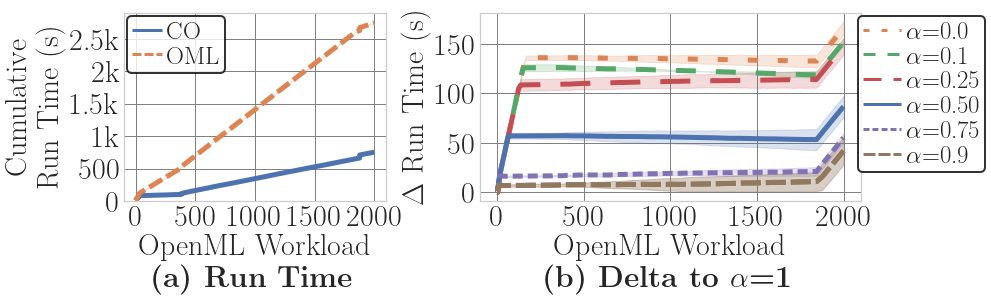

In [252]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(12,4))
gs = GridSpec(1, 7)

ax1 = plt.subplot(gs[0:3])
#ax1 = fig.add_subplot(121)
plot_mat_time(model_mat_times, ax1)
ax2 = plt.subplot(gs[3:7])
plot_alpha_time(alpha_times, ax2)

plt.tight_layout(pad=0,h_pad=0,w_pad=0)
savefig(output_directory+'/model-materialization')

In [242]:
df = execution_times[(execution_times.mat_budget == 0.1) | (execution_times.type == 'OML')]
#plot_executions_time(df, y='cumulative_run_time')
plot_executions_time(df, y='cumulative_run_time',loc=output_directory+'/cumulative-runtime.pgf')


NameError: name 'execution_times' is not defined

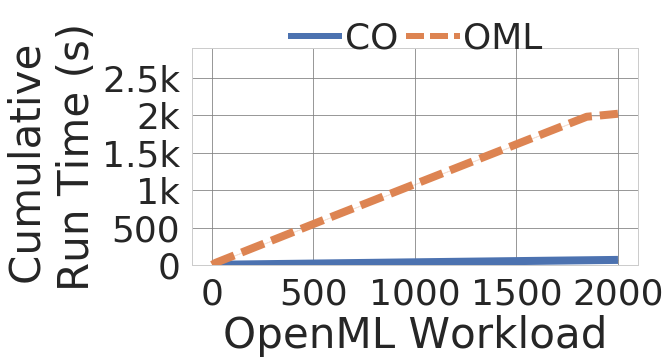

In [19]:
#plot_executions_time(df, y='cumulative_best_run_time')
# plot_executions_time(df, y='cumulative_best_run_time',loc=output_directory+'/bestpipeline-overhead.pgf')